## Setup

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets.folder import default_loader
from torchvision.models import resnet18

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

from dalib.modules.domain_discriminator import DomainDiscriminator
from dalib.adaptation.dann import DomainAdversarialLoss
from dalib.adaptation.cdan import ConditionalDomainAdversarialLoss
from dalib.adaptation.dan import MultipleKernelMaximumMeanDiscrepancy
from dalib.modules.grl import GradientReverseLayer
from dalib.modules.kernels import GaussianKernel

np.float = float

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

BATCH_SIZE = 32
NUM_EPOCHS = 15
LR = 3e-4
WEIGHT_DECAY = 5e-4

results = {}

Using device: cuda


In [13]:
data_dir = "data/PACS"
SOURCE_DOMAIN = "P"
TARGET_DOMAIN = "A"
DOMAINS = {"A": "art_painting", "C": "cartoon", "P": "photo", "S": "sketch"}
CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
NUM_CLASSES = 7


data_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


class ImageTransformer:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, batch):
        batch["pixel_values"] = [
            self.transform(image.convert("RGB")) for image in batch["image"]
        ]
        return batch


image_transformer = ImageTransformer(data_transforms)

source_path = os.path.join(data_dir, SOURCE_DOMAIN)
target_path = os.path.join(data_dir, TARGET_DOMAIN)

source_dataset_full = load_dataset(
    "imagefolder", data_dir=source_path, trust_remote_code=True
)["train"]
target_dataset_full = load_dataset(
    "imagefolder", data_dir=target_path, trust_remote_code=True
)["train"]

source_splits = source_dataset_full.train_test_split(test_size=0.2, seed=SEED)
source_train_set = source_splits["train"]
source_test_set = source_splits["test"]

target_splits = target_dataset_full.train_test_split(test_size=0.2, seed=SEED)
target_train_set = target_splits["train"]
target_test_set = target_splits["test"]

source_train_set.set_transform(image_transformer)
source_test_set.set_transform(image_transformer)
target_train_set.set_transform(image_transformer)
target_test_set.set_transform(image_transformer)


def custom_collate(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.tensor([item["label"] for item in batch])
    return pixel_values, labels


source_train_loader = DataLoader(
    source_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=custom_collate,
    drop_last=True,
)
source_test_loader = DataLoader(
    source_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate,
    drop_last=False,
)
target_train_loader = DataLoader(
    target_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=custom_collate,
    drop_last=True,
)
target_test_loader = DataLoader(
    target_test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate,
    drop_last=False,
)

print(
    f"Source ({DOMAINS[SOURCE_DOMAIN]}): {len(source_train_set)} train, {len(source_test_set)} test samples."
)
print(
    f"Target ({DOMAINS[TARGET_DOMAIN]}): {len(target_train_set)} train, {len(target_test_set)} test samples."
)

Resolving data files:   0%|          | 0/1670 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2048 [00:00<?, ?it/s]

Source (photo): 1336 train, 334 test samples.
Target (art_painting): 1638 train, 410 test samples.


In [14]:
def evaluate(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return accuracy_score(all_labels, all_preds)


def get_features(model, data_loader, device):
    model.eval()
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    all_features, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            features = feature_extractor(images).view(images.size(0), -1)
            all_features.append(features.cpu())
            all_labels.append(labels)
    return torch.cat(all_features), torch.cat(all_labels)


def plot_tsne(
    source_features, source_labels, target_features, target_labels, title, classes_list
):
    combined_features = np.vstack((source_features, target_features))
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
    tsne_results = tsne.fit_transform(combined_features)
    
    # Separate the results back into source and target components
    source_tsne = tsne_results[:len(source_features)]
    target_tsne = tsne_results[len(source_features):]

    # --- 2. Create the 3-Panel Plot ---
    plt.figure(figsize=(24, 7))

    # --- Panel 1: Colored by Domain ---
    plt.subplot(1, 3, 1)
    plt.scatter(source_tsne[:, 0], source_tsne[:, 1], c='blue', label='Source', alpha=0.8)
    plt.scatter(target_tsne[:, 0], target_tsne[:, 1], c='red', label='Target', alpha=0.8)
    plt.title('All Data Colored by Domain')
    plt.legend()
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')


    # --- Panel 2: Source Data, Colored by Class ---
    plt.subplot(1, 3, 2)
    scatter_source = plt.scatter(source_tsne[:, 0], source_tsne[:, 1], c=source_labels, cmap='jet', alpha=0.8)
    plt.title('Source Domain Colored by Class')
    plt.legend(handles=scatter_source.legend_elements()[0], labels=classes_list)
    plt.xlabel('t-SNE feature 1')


    # --- Panel 3: Target Data, Colored by Class ---
    plt.subplot(1, 3, 3)
    scatter_target = plt.scatter(target_tsne[:, 0], target_tsne[:, 1], c=target_labels, cmap='jet', alpha=0.8)
    plt.title('Target Domain Colored by Class')
    plt.legend(handles=scatter_target.legend_elements()[0], labels=classes_list)
    plt.xlabel('t-SNE feature 1')

    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.show()

## Source-Only Baseline

In [74]:
source_only_model = resnet18(pretrained=True)
in_features = source_only_model.fc.in_features
source_only_model.fc = nn.Linear(in_features, NUM_CLASSES)

source_only_model = source_only_model.to(DEVICE)

optimizer = optim.Adam(source_only_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    
    source_only_model.train()
    
    bar = tqdm(source_train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, labels in bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = source_only_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(source_train_loader.dataset)
    bar.set_postfix(loss=epoch_loss)

source_acc = evaluate(source_only_model, source_test_loader, DEVICE)
target_acc = evaluate(source_only_model, target_test_loader, DEVICE)
results["Source-Only"] = {"Source Acc": source_acc, "Target Acc": target_acc}

print(
    f"\nSource-Only Results:\nSource Test Accuracy: {source_acc:.4f}\nTarget Test Accuracy: {target_acc:.4f}\nAccuracy Drop: {source_acc - target_acc:.4f}"
)

Epoch 15/15: 100%|██████████| 41/41 [00:05<00:00,  8.00it/s]



Source-Only Results:
Source Test Accuracy: 0.9341
Target Test Accuracy: 0.4732
Accuracy Drop: 0.4610


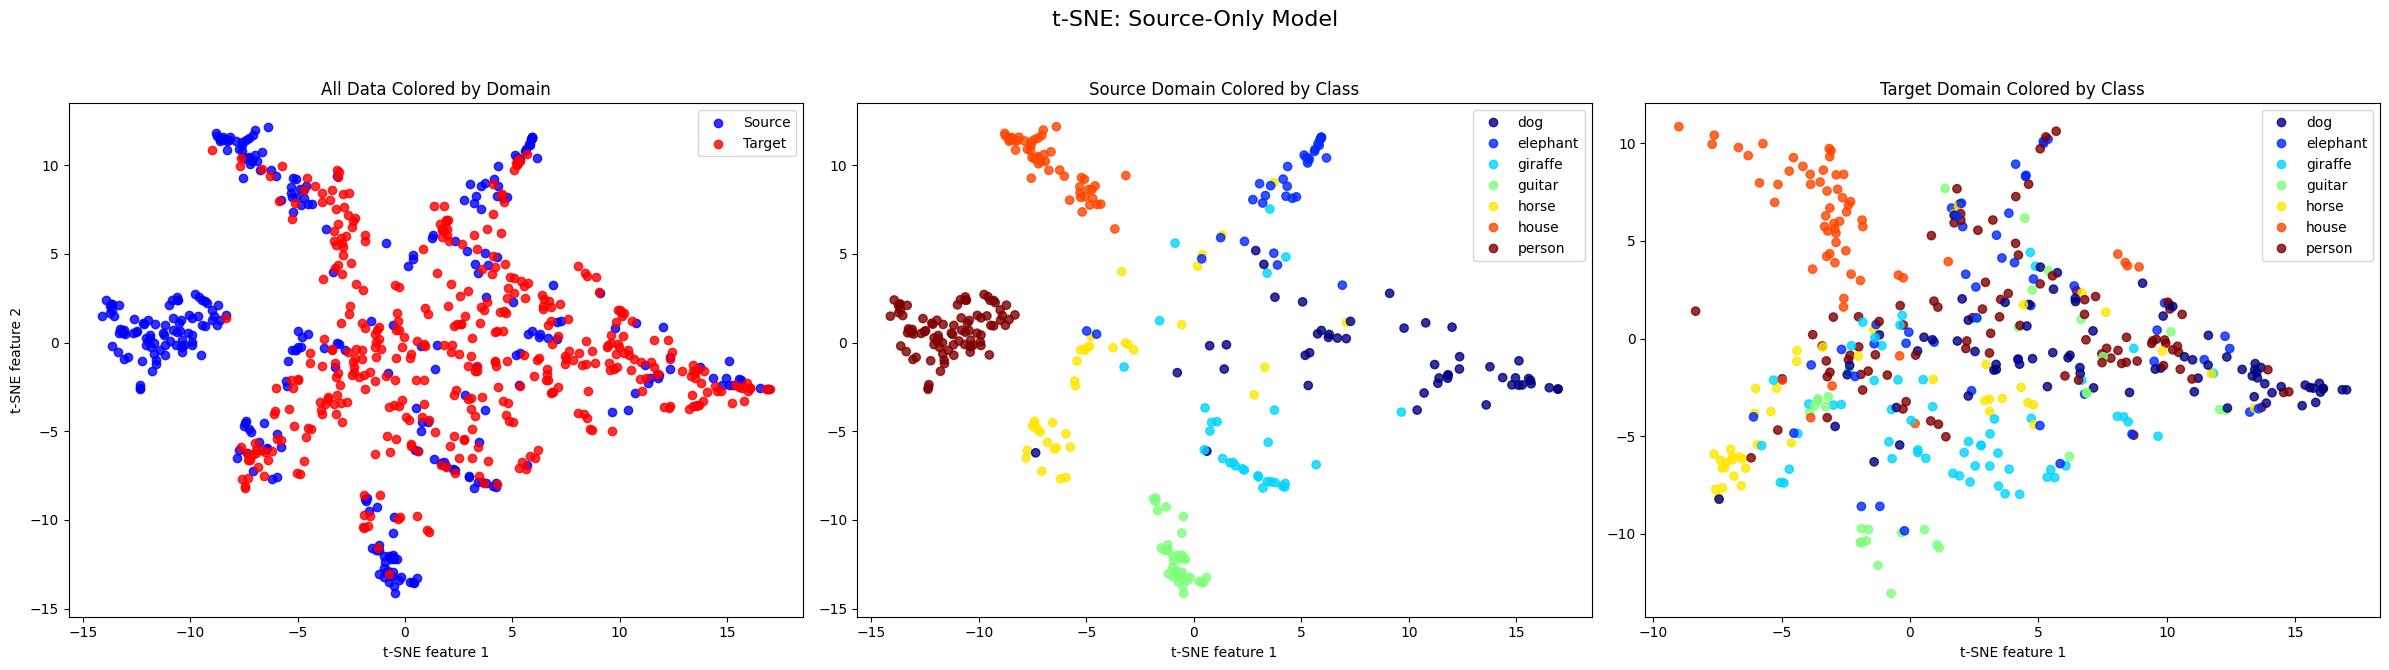

In [76]:
source_features, source_labels = get_features(
    source_only_model, source_test_loader, DEVICE
)
target_features, target_labels = get_features(
    source_only_model, target_test_loader, DEVICE
)
plot_tsne(
    source_features,
    source_labels,
    target_features,
    target_labels,
    "t-SNE: Source-Only Model",
    CLASSES,
)

In [ ]:
# torch.save(source_only_model.state_dict(), "source_only_model.pth")
source_only_model = resnet18(pretrained=True)
in_features = source_only_model.fc.in_features
source_only_model.fc = nn.Linear(in_features, NUM_CLASSES)

source_only_model.load_state_dict(torch.load("source_only_model.pth"))
source_only_model = source_only_model.to(DEVICE)

c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Domain Alignment Based Adaptation:
- DAN (Domain Adaptation Network)
- DANN (DomainAdversarial Neural Network)
- CDAN

### DAN:

In [62]:
LR = 3e-4
NUM_EPOCHS = 15

dan_backbone = resnet18(pretrained=True)
dan_classifier = nn.Linear(dan_backbone.fc.in_features, NUM_CLASSES)
dan_backbone.fc = nn.Identity()

dan_backbone = dan_backbone.to(DEVICE)
dan_classifier = dan_classifier.to(DEVICE)

kernels = [GaussianKernel(sigma) for sigma in [2**-3, 2**-2, 2**-1, 2**0, 2**1, 2**2, 2**3]]

mk_mmd_loss = MultipleKernelMaximumMeanDiscrepancy(kernels=kernels).to(DEVICE)

optimizer_dan = optim.Adam(
    list(dan_backbone.parameters()) + list(dan_classifier.parameters()),
    lr=LR, weight_decay=WEIGHT_DECAY
)

In [63]:
for epoch in range(NUM_EPOCHS):
    dan_backbone.train()
    dan_classifier.train()

    source_iter = iter(source_train_loader)
    target_iter = iter(target_train_loader)

    running_cls_loss = 0.0
    running_transfer_loss = 0.0
    running_loss = 0.0
    num_samples = 0

    num_batches = min(len(source_train_loader), len(target_train_loader))
    pbar = tqdm(range(num_batches), desc=f"DAN Epoch {epoch+1}/{NUM_EPOCHS}")
    for _ in pbar:
        source_images, source_labels = next(source_iter)
        target_images, _ = next(target_iter)
        
        source_images, source_labels = source_images.to(DEVICE), source_labels.to(DEVICE)
        target_images = target_images.to(DEVICE)

        optimizer_dan.zero_grad()

        source_features = dan_backbone(source_images)
        target_features = dan_backbone(target_images)

        cls_loss = criterion(dan_classifier(source_features), source_labels)
        transfer_loss = mk_mmd_loss(source_features, target_features)
        
        total_loss = cls_loss + transfer_loss
        total_loss.backward()
        optimizer_dan.step()

        running_cls_loss += cls_loss.item()
        running_transfer_loss += transfer_loss.item()
        running_loss += total_loss.item()
        num_samples += source_images.size(0)

        pbar.set_postfix({"Total Loss": running_loss / num_samples, "Cls Loss": running_cls_loss / num_samples, "Transfer Loss": running_transfer_loss / num_samples})

    with torch.no_grad():
        dan_model = nn.Sequential(dan_backbone, dan_classifier).to(DEVICE)
        dan_source_acc = evaluate(dan_model, source_test_loader, DEVICE)
        dan_target_acc = evaluate(dan_model, target_test_loader, DEVICE)
        print(f"\nAfter Epoch {epoch+1}: DAN Source Acc: {dan_source_acc:.4f}, Target Acc: {dan_target_acc:.4f}")

    pbar.close()



dan_model = nn.Sequential(dan_backbone, dan_classifier).to(DEVICE)
dan_source_acc = evaluate(dan_model, source_test_loader, DEVICE)
dan_target_acc = evaluate(dan_model, target_test_loader, DEVICE)
results['DAN'] = {'Source Acc': dan_source_acc, 'Target Acc': dan_target_acc}

print(f"\nDAN Results:\nSource Test Accuracy: {dan_source_acc:.4f}\nTarget Test Accuracy: {dan_target_acc:.4f} \nAccuracy Drop: {dan_source_acc - dan_target_acc:.4f}")



DAN Epoch 1/15: 100%|██████████| 41/41 [00:11<00:00,  3.62it/s, Total Loss=0.0085, Cls Loss=0.00994, Transfer Loss=-0.00144] 



After Epoch 1: DAN Source Acc: 0.9401, Target Acc: 0.5927


DAN Epoch 2/15: 100%|██████████| 41/41 [00:12<00:00,  3.34it/s, Total Loss=0.000179, Cls Loss=0.00199, Transfer Loss=-0.00181]



After Epoch 2: DAN Source Acc: 0.9611, Target Acc: 0.5585


DAN Epoch 3/15: 100%|██████████| 41/41 [00:11<00:00,  3.51it/s, Total Loss=-0.00125, Cls Loss=0.00074, Transfer Loss=-0.00199] 



After Epoch 3: DAN Source Acc: 0.9701, Target Acc: 0.6171


DAN Epoch 4/15: 100%|██████████| 41/41 [00:13<00:00,  2.99it/s, Total Loss=-0.00132, Cls Loss=0.000778, Transfer Loss=-0.0021] 



After Epoch 4: DAN Source Acc: 0.9611, Target Acc: 0.6195


DAN Epoch 5/15: 100%|██████████| 41/41 [00:13<00:00,  3.10it/s, Total Loss=-0.00169, Cls Loss=0.000511, Transfer Loss=-0.0022] 



After Epoch 5: DAN Source Acc: 0.9611, Target Acc: 0.5878


DAN Epoch 6/15: 100%|██████████| 41/41 [00:13<00:00,  3.15it/s, Total Loss=-0.0013, Cls Loss=0.000837, Transfer Loss=-0.00214] 



After Epoch 6: DAN Source Acc: 0.9251, Target Acc: 0.5195


DAN Epoch 7/15: 100%|██████████| 41/41 [00:10<00:00,  4.03it/s, Total Loss=-0.0011, Cls Loss=0.00105, Transfer Loss=-0.00214]  



After Epoch 7: DAN Source Acc: 0.9521, Target Acc: 0.6341


DAN Epoch 8/15: 100%|██████████| 41/41 [00:10<00:00,  4.03it/s, Total Loss=5.5e-5, Cls Loss=0.00205, Transfer Loss=-0.002]    



After Epoch 8: DAN Source Acc: 0.9491, Target Acc: 0.4683


DAN Epoch 9/15: 100%|██████████| 41/41 [00:10<00:00,  3.81it/s, Total Loss=-0.00127, Cls Loss=0.000859, Transfer Loss=-0.00212]



After Epoch 9: DAN Source Acc: 0.9521, Target Acc: 0.5659


DAN Epoch 10/15: 100%|██████████| 41/41 [00:12<00:00,  3.18it/s, Total Loss=-0.000765, Cls Loss=0.00125, Transfer Loss=-0.00202] 



After Epoch 10: DAN Source Acc: 0.8922, Target Acc: 0.4634


DAN Epoch 11/15: 100%|██████████| 41/41 [00:10<00:00,  3.79it/s, Total Loss=0.000701, Cls Loss=0.00271, Transfer Loss=-0.002]  



After Epoch 11: DAN Source Acc: 0.9251, Target Acc: 0.5195


DAN Epoch 12/15: 100%|██████████| 41/41 [00:11<00:00,  3.70it/s, Total Loss=-0.000137, Cls Loss=0.00188, Transfer Loss=-0.00202]



After Epoch 12: DAN Source Acc: 0.8862, Target Acc: 0.5000


DAN Epoch 13/15: 100%|██████████| 41/41 [00:11<00:00,  3.50it/s, Total Loss=-0.00113, Cls Loss=0.00096, Transfer Loss=-0.00209] 



After Epoch 13: DAN Source Acc: 0.9401, Target Acc: 0.6220


DAN Epoch 14/15: 100%|██████████| 41/41 [00:14<00:00,  2.91it/s, Total Loss=-0.00208, Cls Loss=0.000142, Transfer Loss=-0.00222]



After Epoch 14: DAN Source Acc: 0.9521, Target Acc: 0.6171


DAN Epoch 15/15: 100%|██████████| 41/41 [00:13<00:00,  3.07it/s, Total Loss=-0.00215, Cls Loss=0.00015, Transfer Loss=-0.0023]  



After Epoch 15: DAN Source Acc: 0.9551, Target Acc: 0.6293

DAN Results:
Source Test Accuracy: 0.9551
Target Test Accuracy: 0.6293 
Accuracy Drop: 0.3258


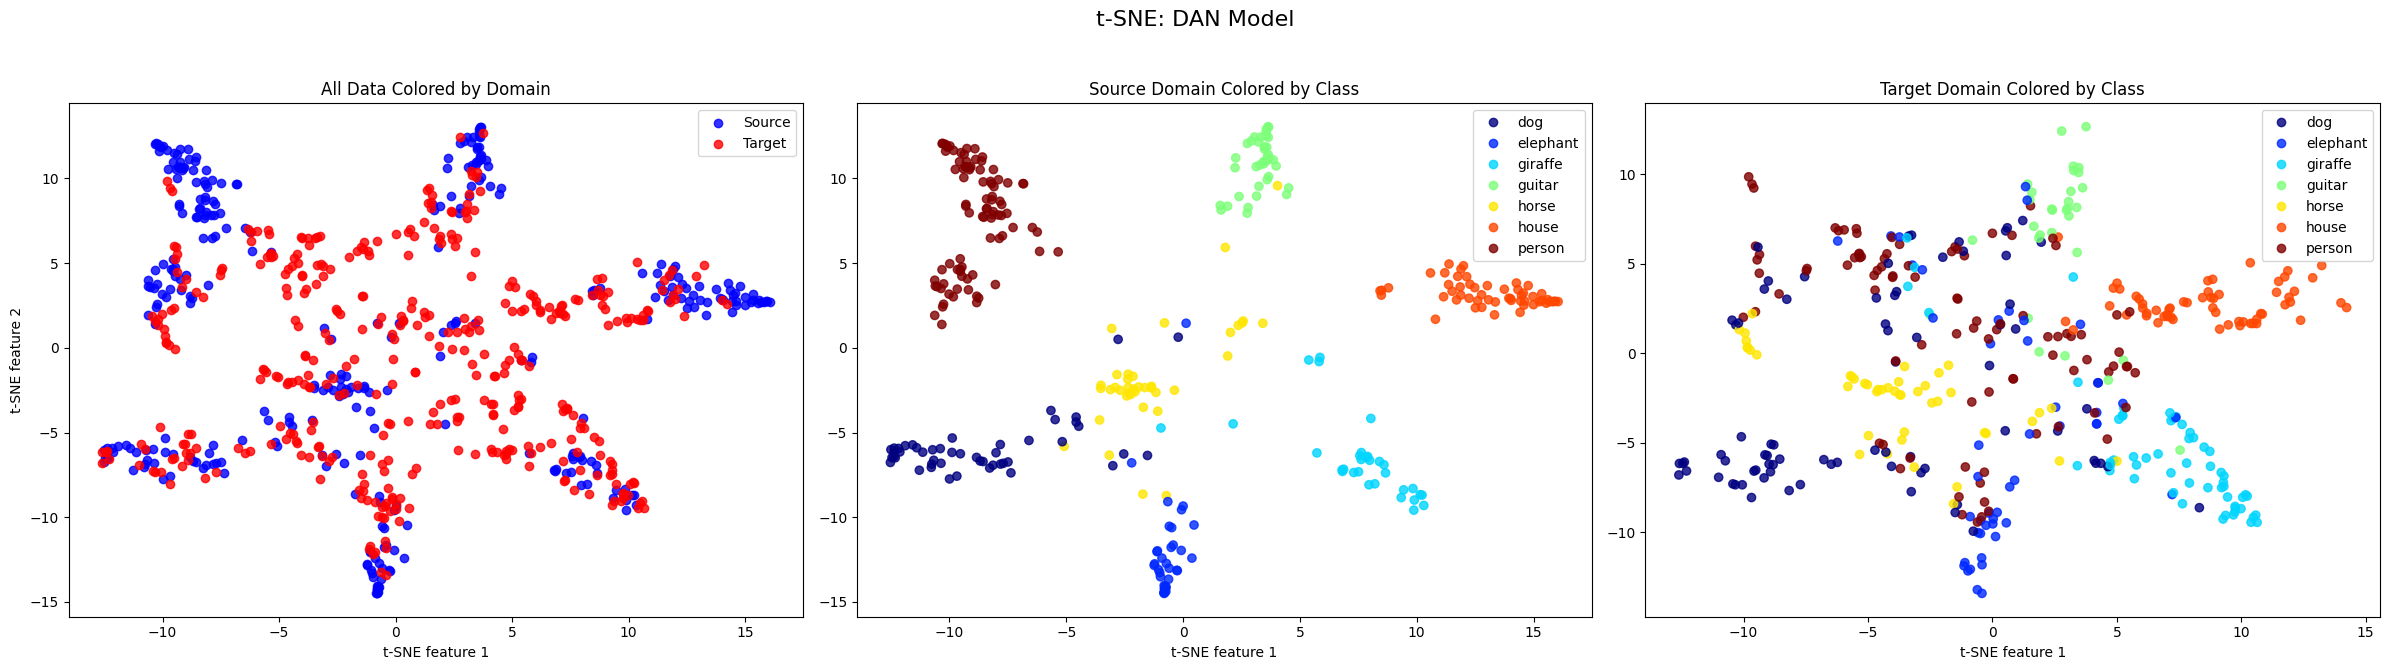

In [64]:
source_features_dan, source_labels_dan = get_features(dan_model, source_test_loader, DEVICE)
target_features_dan, target_labels_dan = get_features(dan_model, target_test_loader, DEVICE)
plot_tsne(source_features_dan, source_labels_dan, target_features_dan, target_labels_dan, "t-SNE: DAN Model", CLASSES)

In [22]:
torch.save(dan_model.state_dict(), "dan_model.pth")

dan_backbone = resnet18(pretrained=True)
dan_classifier = nn.Linear(dan_backbone.fc.in_features, NUM_CLASSES)
dan_backbone.fc = nn.Identity()

dan_model = nn.Sequential(dan_backbone, dan_classifier).to(DEVICE)


dan_model.load_state_dict(torch.load("dan_model.pth"))
dan_model = dan_model.to(DEVICE)

c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### DANN

In [56]:
LR = 3e-4
NUM_EPOCHS = 15

dann_backbone = resnet18(pretrained=True)
dann_classifier = nn.Linear(dann_backbone.fc.in_features, NUM_CLASSES)
dann_backbone.fc = nn.Identity()  # Expose features

dann_backbone = dann_backbone.to(DEVICE)
dann_classifier = dann_classifier.to(DEVICE)

domain_discriminator = DomainDiscriminator(in_feature=dann_classifier.in_features, hidden_size=1024).to(DEVICE)
domain_adv_loss = DomainAdversarialLoss(domain_discriminator).to(DEVICE)

# --- Optimizer ---
optimizer_dann = optim.Adam(
    list(dann_backbone.parameters()) + list(dann_classifier.parameters()) + list(domain_discriminator.parameters()),
    lr=LR, weight_decay=WEIGHT_DECAY
)

c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
for epoch in range(NUM_EPOCHS):
    dann_backbone.train()
    dann_classifier.train()
    
    source_iter = iter(source_train_loader)
    target_iter = iter(target_train_loader)
    
    running_cls_loss = 0.0
    running_transfer_loss = 0.0
    running_loss = 0.0
    num_samples = 0

    pbar = tqdm(range(min(len(source_train_loader), len(target_train_loader))), desc=f"DANN Epoch {epoch+1}/{NUM_EPOCHS}")
    for _ in pbar:

        source_images, source_labels = next(source_iter)
        target_images, _ = next(target_iter)
        
        source_images, source_labels = source_images.to(DEVICE), source_labels.to(DEVICE)
        target_images = target_images.to(DEVICE)

        optimizer_dann.zero_grad()

        # Forward pass through backbone
        source_features = dann_backbone(source_images)
        target_features = dann_backbone(target_images)

        # 1. Classification Loss on Source
        source_outputs = dann_classifier(source_features)
        cls_loss = criterion(source_outputs, source_labels)

        # 2. Domain Adversarial Loss
        transfer_loss = domain_adv_loss(source_features, target_features)
        
        total_loss = cls_loss + transfer_loss
        total_loss.backward()
        optimizer_dann.step()

        running_cls_loss += cls_loss.item()
        running_transfer_loss += transfer_loss.item()
        running_loss += total_loss.item()
        num_samples += source_images.size(0)
        pbar.set_postfix({"Total Loss": running_loss / num_samples, "Cls Loss": running_cls_loss / num_samples, "Transfer Loss": running_transfer_loss / num_samples})

    with torch.no_grad():
        dann_model = nn.Sequential(dann_backbone, dann_classifier).to(DEVICE)
        dann_source_acc = evaluate(dann_model, source_test_loader, DEVICE)
        dann_target_acc = evaluate(dann_model, target_test_loader, DEVICE)
        print(f"\nAfter Epoch {epoch+1}: DANN Source Acc: {dann_source_acc:.4f}, Target Acc: {dann_target_acc:.4f}")

# --- Evaluation ---
dann_model = nn.Sequential(dann_backbone, dann_classifier).to(DEVICE)
dann_source_acc = evaluate(dann_model, source_test_loader, DEVICE)
dann_target_acc = evaluate(dann_model, target_test_loader, DEVICE)
results['DANN'] = {'Source Acc': dann_source_acc, 'Target Acc': dann_target_acc}

print(f"\nDANN Results:\nSource Test Accuracy: {dann_source_acc:.4f}\nTarget Test Accuracy: {dann_target_acc:.4f} \nAccuracy Drop: {dann_source_acc - dann_target_acc:.4f}")

DANN Epoch 1/15: 100%|██████████| 41/41 [00:10<00:00,  4.07it/s, Total Loss=0.0175, Cls Loss=0.00874, Transfer Loss=0.00873]



After Epoch 1: DANN Source Acc: 0.9521, Target Acc: 0.6098


DANN Epoch 2/15: 100%|██████████| 41/41 [00:09<00:00,  4.25it/s, Total Loss=0.00718, Cls Loss=0.00168, Transfer Loss=0.00549]



After Epoch 2: DANN Source Acc: 0.9581, Target Acc: 0.6098


DANN Epoch 3/15: 100%|██████████| 41/41 [00:12<00:00,  3.16it/s, Total Loss=0.0136, Cls Loss=0.000715, Transfer Loss=0.0129]  



After Epoch 3: DANN Source Acc: 0.9521, Target Acc: 0.6244


DANN Epoch 4/15: 100%|██████████| 41/41 [00:10<00:00,  4.00it/s, Total Loss=0.0162, Cls Loss=0.000838, Transfer Loss=0.0154] 



After Epoch 4: DANN Source Acc: 0.9581, Target Acc: 0.6317


DANN Epoch 5/15: 100%|██████████| 41/41 [00:09<00:00,  4.32it/s, Total Loss=0.0196, Cls Loss=0.00223, Transfer Loss=0.0174]



After Epoch 5: DANN Source Acc: 0.9461, Target Acc: 0.6366


DANN Epoch 6/15: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s, Total Loss=0.0196, Cls Loss=0.00133, Transfer Loss=0.0183] 



After Epoch 6: DANN Source Acc: 0.9581, Target Acc: 0.6878


DANN Epoch 7/15: 100%|██████████| 41/41 [00:09<00:00,  4.10it/s, Total Loss=0.0187, Cls Loss=0.00122, Transfer Loss=0.0175]



After Epoch 7: DANN Source Acc: 0.9671, Target Acc: 0.6317


DANN Epoch 8/15: 100%|██████████| 41/41 [00:09<00:00,  4.18it/s, Total Loss=0.0204, Cls Loss=0.0013, Transfer Loss=0.0191]  



After Epoch 8: DANN Source Acc: 0.9371, Target Acc: 0.6415


DANN Epoch 9/15: 100%|██████████| 41/41 [00:12<00:00,  3.26it/s, Total Loss=0.0194, Cls Loss=0.000501, Transfer Loss=0.0189]



After Epoch 9: DANN Source Acc: 0.9641, Target Acc: 0.6634


DANN Epoch 10/15: 100%|██████████| 41/41 [00:12<00:00,  3.35it/s, Total Loss=0.0204, Cls Loss=0.00101, Transfer Loss=0.0194] 



After Epoch 10: DANN Source Acc: 0.9192, Target Acc: 0.6171


DANN Epoch 11/15: 100%|██████████| 41/41 [00:13<00:00,  3.04it/s, Total Loss=0.0215, Cls Loss=0.00179, Transfer Loss=0.0197]



After Epoch 11: DANN Source Acc: 0.9431, Target Acc: 0.5902


DANN Epoch 12/15: 100%|██████████| 41/41 [00:14<00:00,  2.90it/s, Total Loss=0.0208, Cls Loss=0.00106, Transfer Loss=0.0197]



After Epoch 12: DANN Source Acc: 0.9311, Target Acc: 0.6780


DANN Epoch 13/15: 100%|██████████| 41/41 [00:13<00:00,  2.99it/s, Total Loss=0.0215, Cls Loss=0.00125, Transfer Loss=0.0203] 



After Epoch 13: DANN Source Acc: 0.9251, Target Acc: 0.6537


DANN Epoch 14/15: 100%|██████████| 41/41 [00:13<00:00,  2.99it/s, Total Loss=0.0237, Cls Loss=0.00218, Transfer Loss=0.0215]



After Epoch 14: DANN Source Acc: 0.9281, Target Acc: 0.6220


DANN Epoch 15/15: 100%|██████████| 41/41 [00:14<00:00,  2.82it/s, Total Loss=0.0214, Cls Loss=0.00174, Transfer Loss=0.0197]



After Epoch 15: DANN Source Acc: 0.9341, Target Acc: 0.6610

DANN Results:
Source Test Accuracy: 0.9341
Target Test Accuracy: 0.6610 
Accuracy Drop: 0.2732


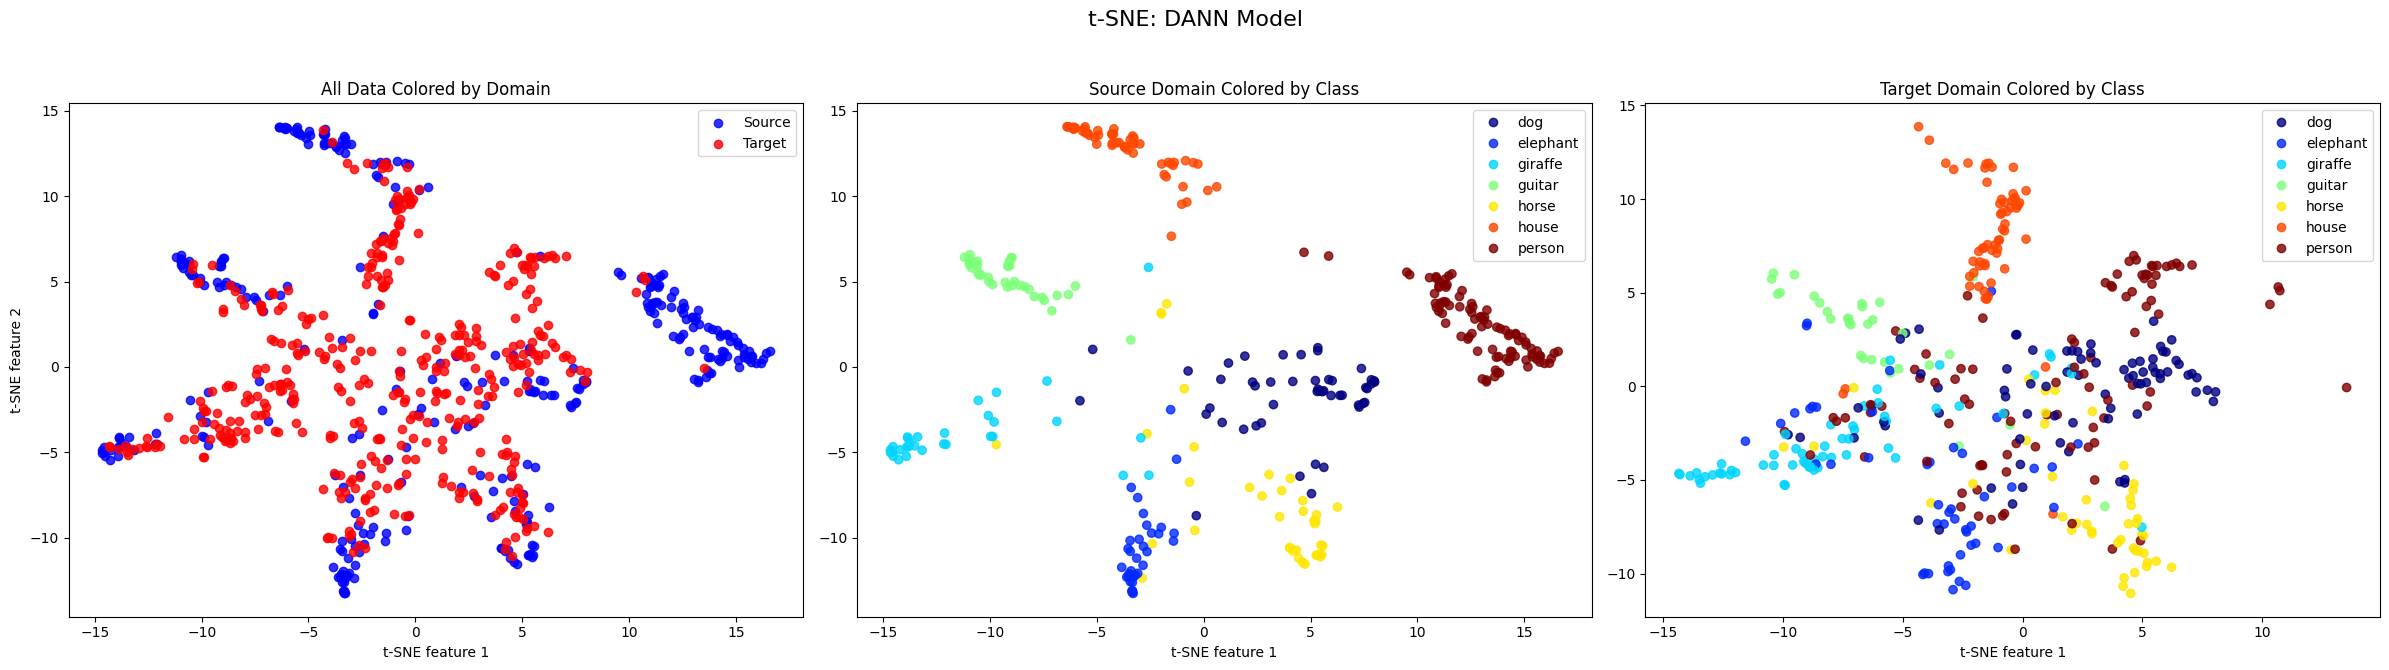

In [59]:
source_features_dann, source_labels_dann = get_features(dann_model, source_test_loader, DEVICE)
target_features_dann, target_labels_dann = get_features(dann_model, target_test_loader, DEVICE)
plot_tsne(source_features_dann, source_labels_dann, target_features_dann, target_labels_dann, "t-SNE: DANN Model", CLASSES)

In [ ]:
# torch.save(dann_model.state_dict(), "dann_model.pth")

dann_backbone = resnet18(pretrained=True)
dann_classifier = nn.Linear(dann_backbone.fc.in_features, NUM_CLASSES)
dann_backbone.fc = nn.Identity()

dann_model = nn.Sequential(dann_backbone, dann_classifier).to(DEVICE)
dann_model.load_state_dict(torch.load("dann_model.pth"))

c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

### CDAN

In [ ]:
LR = 3e-4
NUM_EPOCHS = 15

cdan_backbone = resnet18(pretrained=True)
cdan_classifier = nn.Linear(cdan_backbone.fc.in_features, NUM_CLASSES)
cdan_backbone.fc = nn.Identity()

cdan_backbone = cdan_backbone.to(DEVICE)
cdan_classifier = cdan_classifier.to(DEVICE)

domain_discriminator_cdan = DomainDiscriminator(in_feature=cdan_classifier.in_features * NUM_CLASSES, hidden_size=1024).to(DEVICE)
cdan_loss = ConditionalDomainAdversarialLoss(domain_discriminator_cdan, reduction='mean').to(DEVICE)

optimizer_cdan = optim.Adam(
    list(cdan_backbone.parameters()) + list(cdan_classifier.parameters()) + list(domain_discriminator_cdan.parameters()),
    lr=LR, weight_decay=WEIGHT_DECAY
)

from torch.optim.lr_scheduler import StepLR
scheduler_cdan = StepLR(optimizer_cdan, step_size=5, gamma=0.1)

c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for epoch in range(NUM_EPOCHS):
    cdan_backbone.train()
    cdan_classifier.train()
    
    source_iter = iter(source_train_loader)
    target_iter = iter(target_train_loader)

    running_cls_loss = 0.0
    running_transfer_loss = 0.0
    running_loss = 0.0
    num_samples = 0

    bar = tqdm(range(min(len(source_train_loader), len(target_train_loader))), desc=f"CDAN Epoch {epoch+1}/{NUM_EPOCHS}")
    for _ in bar:
        source_images, source_labels = next(source_iter)
        target_images, _ = next(target_iter)

        source_images, source_labels = source_images.to(DEVICE), source_labels.to(DEVICE)
        target_images = target_images.to(DEVICE)
        
        optimizer_cdan.zero_grad()

        # Forward pass
        source_features = cdan_backbone(source_images)
        target_features = cdan_backbone(target_images)
        source_outputs = cdan_classifier(source_features)
        target_outputs = cdan_classifier(target_features)

        # 1. Classification Loss
        cls_loss = criterion(source_outputs, source_labels)

        # 2. Conditional Adversarial Loss
        transfer_loss = cdan_loss(source_features, source_outputs, target_features, target_outputs)

        total_loss = cls_loss + transfer_loss
        total_loss.backward()
        optimizer_cdan.step()

        running_cls_loss += cls_loss.item()
        running_transfer_loss += transfer_loss.item()
        running_loss += total_loss.item()
        num_samples += source_images.size(0)

        bar.set_postfix({
            "cls_loss": running_cls_loss / num_samples,
            "transfer_loss": running_transfer_loss / num_samples,
            "total_loss": running_loss / num_samples
        })
        
    with torch.no_grad():
        cdan_model = nn.Sequential(cdan_backbone, cdan_classifier).to(DEVICE)
        cdan_source_acc = evaluate(cdan_model, source_test_loader, DEVICE)
        cdan_target_acc = evaluate(cdan_model, target_test_loader, DEVICE)
        print(f"\nAfter Epoch {epoch+1}: CDAN Source Acc: {cdan_source_acc:.4f}, Target Acc: {cdan_target_acc:.4f}")

    scheduler_cdan.step()


# --- Evaluation ---
cdan_model = nn.Sequential(cdan_backbone, cdan_classifier).to(DEVICE)
cdan_source_acc = evaluate(cdan_model, source_test_loader, DEVICE)
cdan_target_acc = evaluate(cdan_model, target_test_loader, DEVICE)
results['CDAN'] = {'Source Acc': cdan_source_acc, 'Target Acc': cdan_target_acc}

print(f"\nCDAN Results:\nSource Test Accuracy: {cdan_source_acc:.4f}\nTarget Test Accuracy: {cdan_target_acc:.4f}")

CDAN Epoch 1/15: 100%|██████████| 41/41 [00:10<00:00,  3.82it/s, cls_loss=0.0141, transfer_loss=0.0119, total_loss=0.026] 



After Epoch 1: CDAN Source Acc: 0.9790, Target Acc: 0.6683


CDAN Epoch 2/15: 100%|██████████| 41/41 [00:10<00:00,  4.06it/s, cls_loss=0.00116, transfer_loss=0.00595, total_loss=0.00711]



After Epoch 2: CDAN Source Acc: 0.9820, Target Acc: 0.6976


CDAN Epoch 3/15: 100%|██████████| 41/41 [00:10<00:00,  4.08it/s, cls_loss=0.000531, transfer_loss=0.00458, total_loss=0.00511]



After Epoch 3: CDAN Source Acc: 0.9850, Target Acc: 0.7098


CDAN Epoch 4/15: 100%|██████████| 41/41 [00:10<00:00,  4.07it/s, cls_loss=0.000386, transfer_loss=0.00401, total_loss=0.00439]



After Epoch 4: CDAN Source Acc: 0.9790, Target Acc: 0.7073


CDAN Epoch 5/15: 100%|██████████| 41/41 [00:11<00:00,  3.48it/s, cls_loss=0.000178, transfer_loss=0.00278, total_loss=0.00296]



After Epoch 5: CDAN Source Acc: 0.9850, Target Acc: 0.7073


CDAN Epoch 6/15: 100%|██████████| 41/41 [00:13<00:00,  3.12it/s, cls_loss=0.000175, transfer_loss=0.00285, total_loss=0.00302]



After Epoch 6: CDAN Source Acc: 0.9850, Target Acc: 0.7122


CDAN Epoch 7/15: 100%|██████████| 41/41 [00:13<00:00,  3.11it/s, cls_loss=0.000177, transfer_loss=0.00256, total_loss=0.00274]



After Epoch 7: CDAN Source Acc: 0.9880, Target Acc: 0.7171


CDAN Epoch 8/15: 100%|██████████| 41/41 [00:13<00:00,  3.07it/s, cls_loss=0.000168, transfer_loss=0.0023, total_loss=0.00246] 



After Epoch 8: CDAN Source Acc: 0.9850, Target Acc: 0.7073


CDAN Epoch 9/15: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s, cls_loss=0.000162, transfer_loss=0.00252, total_loss=0.00268]



After Epoch 9: CDAN Source Acc: 0.9820, Target Acc: 0.7049


CDAN Epoch 10/15: 100%|██████████| 41/41 [00:09<00:00,  4.16it/s, cls_loss=0.000233, transfer_loss=0.00253, total_loss=0.00277]



After Epoch 10: CDAN Source Acc: 0.9820, Target Acc: 0.7073


CDAN Epoch 11/15: 100%|██████████| 41/41 [00:13<00:00,  3.14it/s, cls_loss=0.000177, transfer_loss=0.0024, total_loss=0.00258] 



After Epoch 11: CDAN Source Acc: 0.9850, Target Acc: 0.7122


CDAN Epoch 12/15: 100%|██████████| 41/41 [00:13<00:00,  3.03it/s, cls_loss=0.000151, transfer_loss=0.00228, total_loss=0.00243]



After Epoch 12: CDAN Source Acc: 0.9850, Target Acc: 0.7146


CDAN Epoch 13/15: 100%|██████████| 41/41 [00:13<00:00,  2.98it/s, cls_loss=0.00016, transfer_loss=0.00235, total_loss=0.00251] 



After Epoch 13: CDAN Source Acc: 0.9820, Target Acc: 0.7171


CDAN Epoch 14/15: 100%|██████████| 41/41 [00:13<00:00,  3.14it/s, cls_loss=0.000147, transfer_loss=0.00233, total_loss=0.00247]



After Epoch 14: CDAN Source Acc: 0.9820, Target Acc: 0.7171


CDAN Epoch 15/15: 100%|██████████| 41/41 [00:10<00:00,  3.74it/s, cls_loss=0.000139, transfer_loss=0.00236, total_loss=0.0025] 



After Epoch 15: CDAN Source Acc: 0.9850, Target Acc: 0.7073

CDAN Results:
Source Test Accuracy: 0.9850
Target Test Accuracy: 0.7073


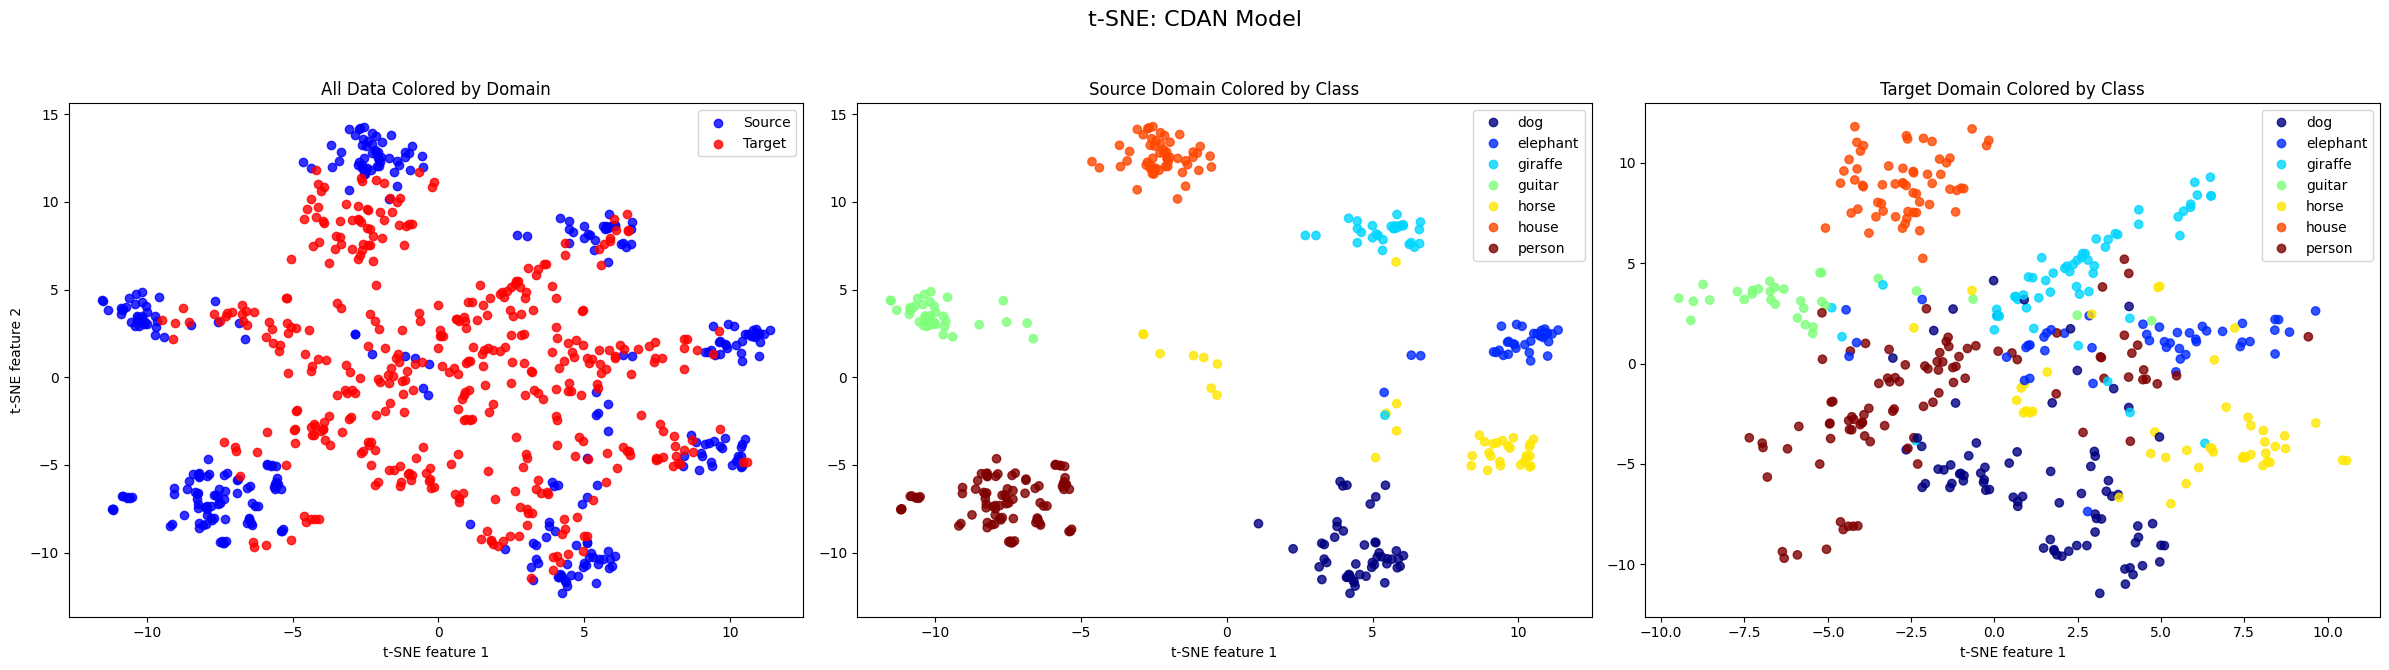

In [55]:
source_features_cdan, source_labels_cdan = get_features(cdan_model, source_test_loader, DEVICE)
target_features_cdan, target_labels_cdan = get_features(cdan_model, target_test_loader, DEVICE)
plot_tsne(source_features_cdan, source_labels_cdan, target_features_cdan, target_labels_cdan, "t-SNE: CDAN Model", CLASSES)

In [54]:
# torch.save(cdan_model.state_dict(), "cdan_model.pth")

cdan_backbone = resnet18(pretrained=True)
cdan_classifier = nn.Linear(cdan_backbone.fc.in_features, NUM_CLASSES)
cdan_backbone.fc = nn.Identity()

cdan_backbone = cdan_backbone.to(DEVICE)
cdan_classifier = cdan_classifier.to(DEVICE)

cdan_model = nn.Sequential(cdan_backbone, cdan_classifier).to(DEVICE)
cdan_model.load_state_dict(torch.load("cdan_model.pth"))
cdan_model = cdan_model.to(DEVICE)

c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Domain Alignment Analysis

In [80]:
import pickle 

with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)
        
# with open('results.pkl', 'rb') as f:
#     results = pickle.load(f)

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_kde_clouds(source_2d, target_2d, title):
    """
    Visualizes the 2D feature distributions of source and target domains
    using Kernel Density Estimate (KDE) plots.

    Args:
        source_2d (np.array): 2D coordinates for the source data (e.g., from t-SNE).
        target_2d (np.array): 2D coordinates for the target data (e.g., from t-SNE).
        title (str): The title for the plot.
    """
    plt.figure(figsize=(10, 8))
    
    # Plot the source distribution
    sns.kdeplot(
        x=source_2d[:, 0], 
        y=source_2d[:, 1], 
        cmap="Blues", 
        fill=True, 
        alpha=0.6,
        label='Source'
    )
    
    # Plot the target distribution on the same axes
    sns.kdeplot(
        x=target_2d[:, 0], 
        y=target_2d[:, 1], 
        cmap="Reds", 
        fill=True, 
        alpha=0.6,
        label='Target'
    )
    
    plt.title(title, fontsize=16)
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.legend()
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


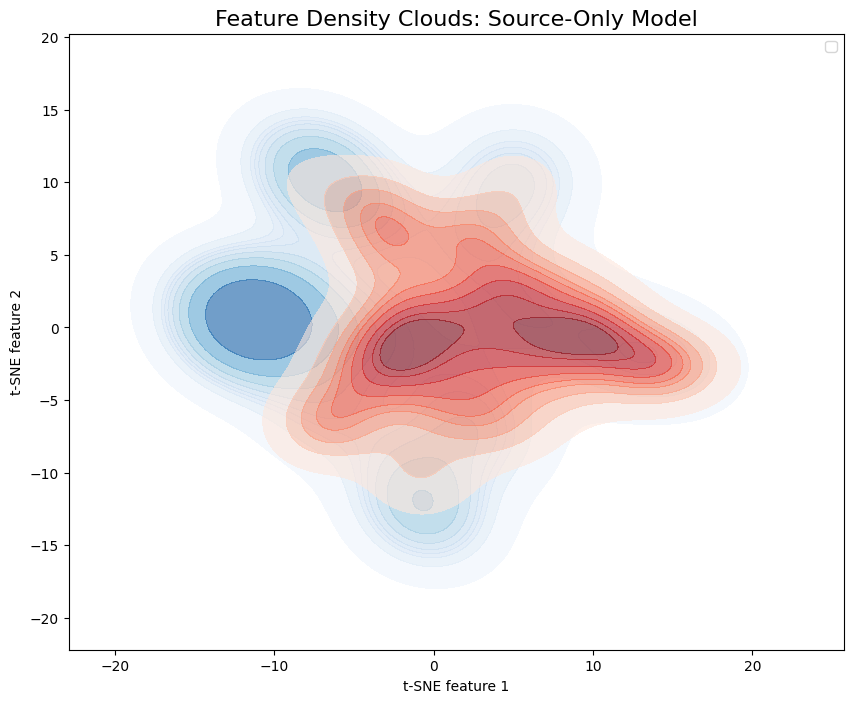

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


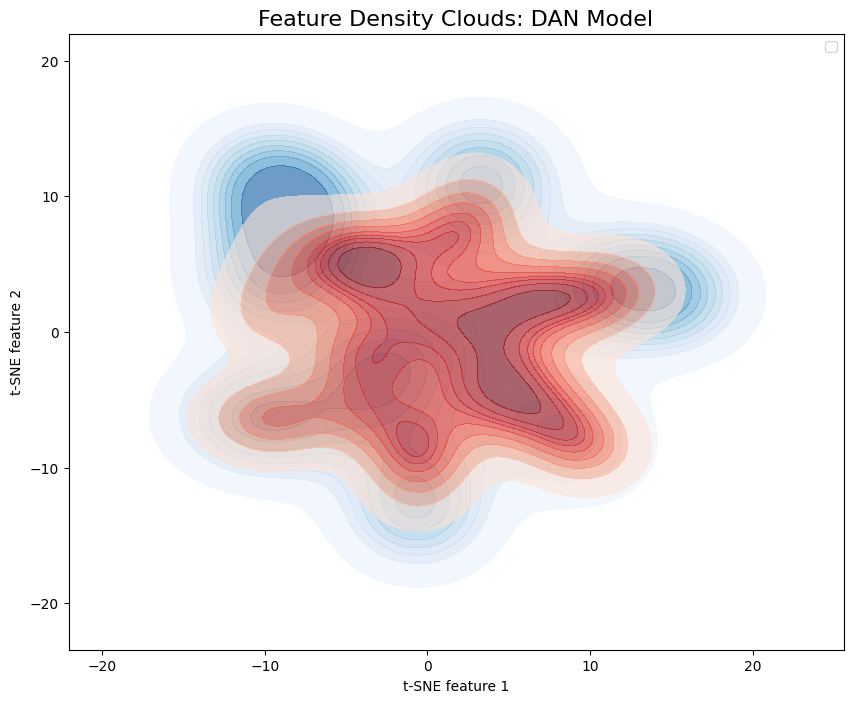

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


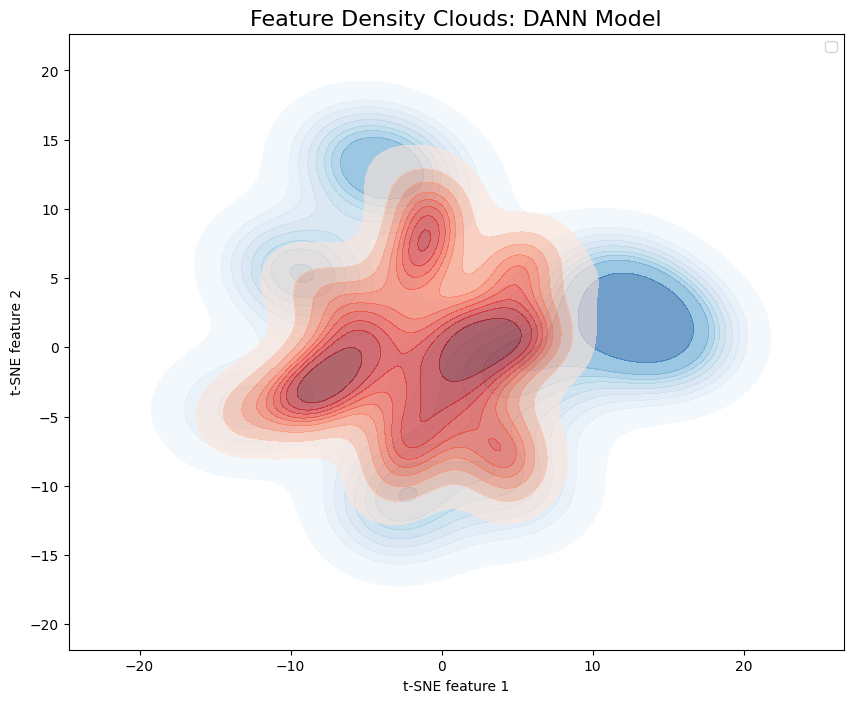

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


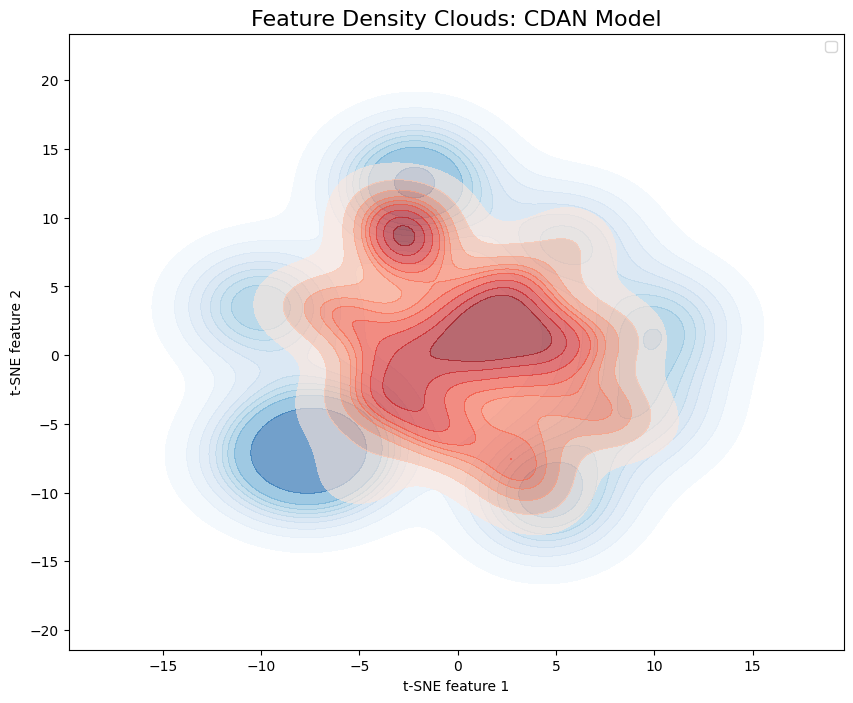

In [84]:
"""Source Model"""

combined_features_source_only = np.vstack(
    (source_features.cpu().detach().numpy(), target_features.cpu().detach().numpy())
)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results_source_only = tsne.fit_transform(combined_features_source_only)

source_tsne_source_only = tsne_results_source_only[: len(source_features)]
target_tsne_source_only = tsne_results_source_only[len(source_features) :]

plot_kde_clouds(
    source_tsne_source_only,
    target_tsne_source_only,
    "Feature Density Clouds: Source-Only Model",
)

"""DAN"""
combined_features_dan = np.vstack(
    (
        source_features_dan.cpu().detach().numpy(),
        target_features_dan.cpu().detach().numpy(),
    )
)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results_dan = tsne.fit_transform(combined_features_dan)

source_tsne_dan = tsne_results_dan[: len(source_features_dan)]
target_tsne_dan = tsne_results_dan[len(source_features_dan) :]

plot_kde_clouds(source_tsne_dan, target_tsne_dan, "Feature Density Clouds: DAN Model")

"""DANN"""
combined_features_dann = np.vstack(
    (
        source_features_dann.cpu().detach().numpy(),
        target_features_dann.cpu().detach().numpy(),
    )
)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results_dann = tsne.fit_transform(combined_features_dann)

source_tsne_dann = tsne_results_dann[: len(source_features_dann)]
target_tsne_dann = tsne_results_dann[len(source_features_dann) :]

plot_kde_clouds(
    source_tsne_dann, target_tsne_dann, "Feature Density Clouds: DANN Model"
)

"""CDAN"""
source_features_cdan, _ = get_features(cdan_model, source_test_loader, DEVICE)
target_features_cdan, _ = get_features(cdan_model, target_test_loader, DEVICE)

combined_features = np.vstack(
    (
        source_features_cdan.cpu().detach().numpy(),
        target_features_cdan.cpu().detach().numpy(),
    )
)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results = tsne.fit_transform(combined_features)

source_tsne_cdan = tsne_results[: len(source_features_cdan)]
target_tsne_cdan = tsne_results[len(source_features_cdan) :]

plot_kde_clouds(
    source_tsne_cdan, target_tsne_cdan, "Feature Density Clouds: CDAN Model"
)

In [86]:
def calculate_proxy_a_distance(source_feat, target_feat, seed):
    X = np.vstack((source_feat, target_feat))
    y = np.concatenate((np.zeros(source_feat.shape[0]), np.ones(target_feat.shape[0])))
    clf = LogisticRegression(random_state=seed, max_iter=1000).fit(X, y)
    return 1 - clf.score(X, y)

print("\n--- Proxy A-Distance (Higher Error = Better Alignment) ---")

proxy_source_only = calculate_proxy_a_distance(source_features.cpu().detach().numpy(), target_features.cpu().detach().numpy(), SEED)
proxy_dann = calculate_proxy_a_distance(source_features_dann.cpu().detach().numpy(), target_features_dann.cpu().detach().numpy(), SEED)
proxy_dan = calculate_proxy_a_distance(source_features_dan.cpu().detach().numpy(), target_features_dan.cpu().detach().numpy(), SEED)
proxy_cdan = calculate_proxy_a_distance(source_features_cdan.cpu().detach().numpy(), target_features_cdan.cpu().detach().numpy(), SEED)

print(f"Source-Only Proxy A-Distance Error: {proxy_source_only:.4f}")
print(f"DAN Proxy A-Distance Error: {proxy_dan:.4f}")
print(f"DANN Proxy A-Distance Error: {proxy_dann:.4f}")
print(f"CDAN Proxy A-Distance Error: {proxy_cdan:.4f}")


--- Proxy A-Distance (Higher Error = Better Alignment) ---
Source-Only Proxy A-Distance Error: 0.0336
DAN Proxy A-Distance Error: 0.0175
DANN Proxy A-Distance Error: 0.0511
CDAN Proxy A-Distance Error: 0.0000


The three rarest classes in the target training set are: ['elephant', 'horse', 'guitar']

--- F1-Scores for the Three Rarest Classes ---


,elephant,horse,guitar
Source-Only,0.303797,0.500000,0.411765
DAN,0.494624,0.571429,0.625000
DANN,0.557692,0.594059,0.766667
CDAN,0.632653,0.630631,0.742857



--- Confusion Matrices on Target Test Set ---


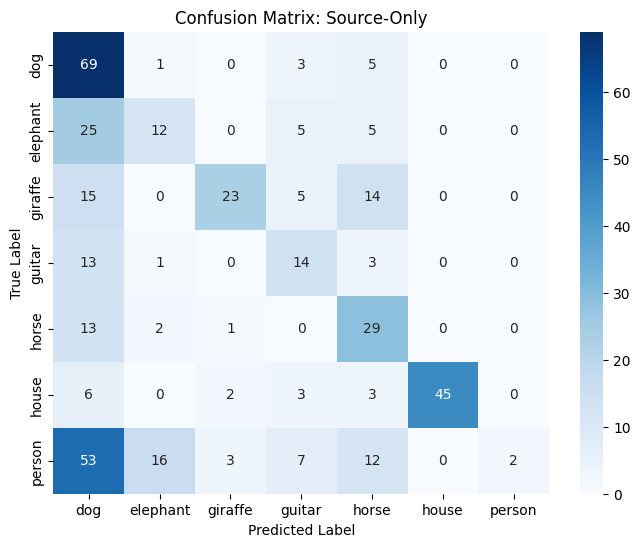

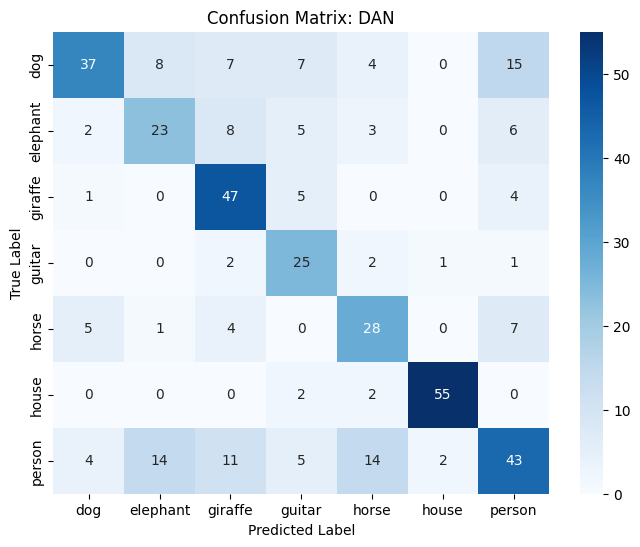

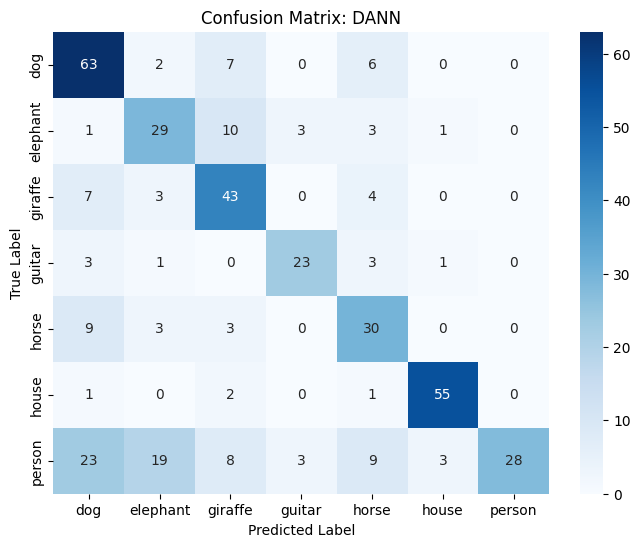

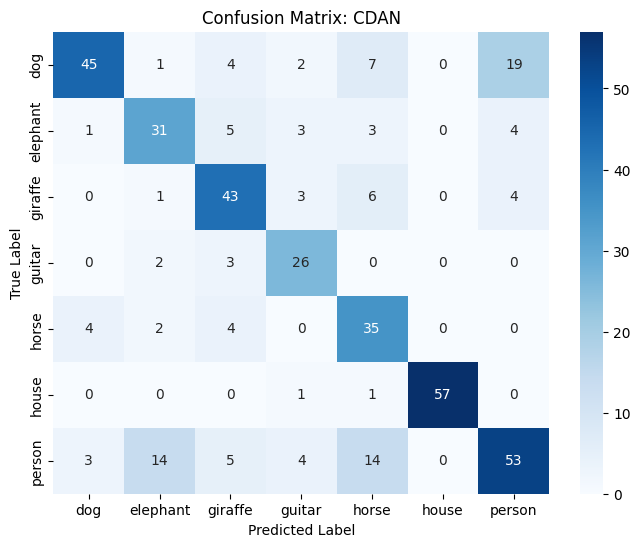

In [ ]:
from collections import Counter
import pandas as pd

# Define a simple function that just returns the batch it receives
def passthrough_transform(batch):
    return batch

# Temporarily replace the image transformer with our pass-through function
target_train_set.set_transform(passthrough_transform)

# Now, safely access the 'label' column
target_train_labels = target_train_set['label']

# IMPORTANT: Restore the original transform so your DataLoaders still work correctly
target_train_set.set_transform(image_transformer)

# --- The rest of the cell proceeds as before ---
class_counts = Counter(target_train_labels)
rarest_classes_indices = [item[0] for item in class_counts.most_common()[-3:]]
rarest_classes_names = [CLASSES[i] for i in rarest_classes_indices]

print(f"The three rarest classes in the target training set are: {rarest_classes_names}")

from sklearn.metrics import f1_score

def get_all_preds_labels(model, data_loader, device):
    """Helper function to get all predictions and labels for a dataset."""
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Calculate per-class F1 scores for all models on the target test set
models_to_analyze = {
    "Source-Only": source_only_model,
    "DAN": dan_model,
    "DANN": dann_model,
    "CDAN": cdan_model
}

f1_results = {}
for name, model in models_to_analyze.items():
    if model:
        preds, labels = get_all_preds_labels(model, target_test_loader, DEVICE)
        per_class_f1 = f1_score(labels, preds, average=None, zero_division=0)
        # Store F1 scores for the three rarest classes
        f1_results[name] = {rarest_classes_names[i]: per_class_f1[rarest_classes_indices[i]] for i in range(len(rarest_classes_names))}

f1_df = pd.DataFrame(f1_results).T
print("\n--- F1-Scores for the Three Rarest Classes ---")
display(f1_df)

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(preds, labels, title, class_names):
    """Plots a confusion matrix using seaborn."""
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

print("\n--- Confusion Matrices on Target Test Set ---")
for name, model in models_to_analyze.items():
    if model:
        preds, labels = get_all_preds_labels(model, target_test_loader, DEVICE)
        plot_confusion_matrix(preds, labels, f"Confusion Matrix: {name}", CLASSES)

## Self-Training

In [183]:
top_k_per_class = 20

all_target_preds = []
source_only_model.eval()
with torch.no_grad():
    for i in tqdm(range(len(target_train_set)), desc="Getting all target predictions"):
        sample = target_train_set[i]
        image_tensor = sample['pixel_values'].unsqueeze(0).to(DEVICE)
        
        outputs = source_only_model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1).squeeze(0) 
        
        original_image = sample['image']
        all_target_preds.append((original_image, probabilities))

pseudo_labeled_data = []
preds_by_class = [[] for _ in range(NUM_CLASSES)]
for img, probs in all_target_preds:
    confidence, predicted_class = torch.max(probs, 0)
    preds_by_class[predicted_class.item()].append((img, confidence.item()))

for i, class_preds in enumerate(preds_by_class):
    class_preds.sort(key=lambda x: x[1], reverse=True)
    for img, conf in class_preds[:top_k_per_class]:
        pseudo_labeled_data.append((img, i))

print(f"Generated {len(pseudo_labeled_data)} class-balanced pseudo-labels ({top_k_per_class} for each of the {NUM_CLASSES} classes).")


Getting all target predictions: 100%|██████████| 1638/1638 [00:12<00:00, 129.69it/s]


Generated 125 class-balanced pseudo-labels (20 for each of the 7 classes).


In [184]:
class PseudoLabelDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image, label = self.data[idx]
        return self.transform(image), label


def passthrough_transform(batch):
    return batch

source_train_set.set_transform(passthrough_transform)

source_train_images_labels = [(sample['image'], sample['label']) for sample in source_train_set]

source_train_set.set_transform(image_transformer)

combined_data = source_train_images_labels + pseudo_labeled_data

combined_dataset = PseudoLabelDataset(combined_data, data_transforms) 
combined_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [186]:
LR = (3e-4)
NUM_EPOCHS = 15

self_training_model = resnet18(pretrained=True)
in_features = self_training_model.fc.in_features
self_training_model.fc = nn.Linear(in_features, NUM_CLASSES)

self_training_model.load_state_dict(torch.load("source_only_model.pth"))
self_training_model = self_training_model.to(DEVICE)

optimizer_st = optim.Adam(self_training_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


In [187]:
for epoch in range(NUM_EPOCHS):
    self_training_model.train()

    running_loss = 0.0
    num_samples = 0

    bar = tqdm(combined_loader, desc=f"Fine-tuning Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, labels in bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer_st.zero_grad()
        outputs = self_training_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_st.step()
        running_loss += loss.item() * images.size(0)
        num_samples += images.size(0)
        bar.set_postfix(loss=running_loss / num_samples)
    
    with torch.no_grad():
        st_source_acc = evaluate(self_training_model, source_test_loader, DEVICE)
        st_target_acc = evaluate(self_training_model, target_test_loader, DEVICE)
        print(f"\nAfter Epoch {epoch+1}: Self-Training Source Acc: {st_source_acc:.4f}, Target Acc: {st_target_acc:.4f}")



st_source_acc = evaluate(self_training_model, source_test_loader, DEVICE)
st_target_acc = evaluate(self_training_model, target_test_loader, DEVICE)
results['Self-Training'] = {'Source Acc': st_source_acc, 'Target Acc': st_target_acc}

print(f"\nSelf-Training Results:\nSource Test Accuracy: {st_source_acc:.4f}\nTarget Test Accuracy: {st_target_acc:.4f} \nAccuracy Drop: {st_source_acc - st_target_acc:.4f}")

Fine-tuning Epoch 1/15:   0%|          | 0/46 [00:00<?, ?it/s]

Fine-tuning Epoch 1/15: 100%|██████████| 46/46 [00:06<00:00,  6.81it/s, loss=0.0671]



After Epoch 1: Self-Training Source Acc: 0.9132, Target Acc: 0.4976


Fine-tuning Epoch 2/15: 100%|██████████| 46/46 [00:07<00:00,  5.81it/s, loss=0.0441]



After Epoch 2: Self-Training Source Acc: 0.9222, Target Acc: 0.4805


Fine-tuning Epoch 3/15: 100%|██████████| 46/46 [00:06<00:00,  7.08it/s, loss=0.055] 



After Epoch 3: Self-Training Source Acc: 0.9192, Target Acc: 0.4780


Fine-tuning Epoch 4/15: 100%|██████████| 46/46 [00:06<00:00,  7.26it/s, loss=0.0449]



After Epoch 4: Self-Training Source Acc: 0.8892, Target Acc: 0.4634


Fine-tuning Epoch 5/15: 100%|██████████| 46/46 [00:06<00:00,  7.33it/s, loss=0.0476]



After Epoch 5: Self-Training Source Acc: 0.9371, Target Acc: 0.5098


Fine-tuning Epoch 6/15: 100%|██████████| 46/46 [00:06<00:00,  7.26it/s, loss=0.0273]



After Epoch 6: Self-Training Source Acc: 0.9491, Target Acc: 0.5805


Fine-tuning Epoch 7/15: 100%|██████████| 46/46 [00:06<00:00,  7.17it/s, loss=0.0068] 



After Epoch 7: Self-Training Source Acc: 0.9521, Target Acc: 0.6171


Fine-tuning Epoch 8/15: 100%|██████████| 46/46 [00:06<00:00,  7.18it/s, loss=0.00203]



After Epoch 8: Self-Training Source Acc: 0.9611, Target Acc: 0.6415


Fine-tuning Epoch 9/15: 100%|██████████| 46/46 [00:06<00:00,  6.97it/s, loss=0.00101] 



After Epoch 9: Self-Training Source Acc: 0.9731, Target Acc: 0.6439


Fine-tuning Epoch 10/15: 100%|██████████| 46/46 [00:06<00:00,  7.53it/s, loss=0.000649]



After Epoch 10: Self-Training Source Acc: 0.9611, Target Acc: 0.6317


Fine-tuning Epoch 11/15: 100%|██████████| 46/46 [00:06<00:00,  7.32it/s, loss=0.000799]



After Epoch 11: Self-Training Source Acc: 0.9731, Target Acc: 0.6171


Fine-tuning Epoch 12/15: 100%|██████████| 46/46 [00:07<00:00,  6.03it/s, loss=0.00118] 



After Epoch 12: Self-Training Source Acc: 0.9760, Target Acc: 0.6220


Fine-tuning Epoch 13/15: 100%|██████████| 46/46 [00:06<00:00,  6.93it/s, loss=0.000581]



After Epoch 13: Self-Training Source Acc: 0.9850, Target Acc: 0.6439


Fine-tuning Epoch 14/15: 100%|██████████| 46/46 [00:06<00:00,  7.24it/s, loss=0.00057] 



After Epoch 14: Self-Training Source Acc: 0.9731, Target Acc: 0.6415


Fine-tuning Epoch 15/15: 100%|██████████| 46/46 [00:06<00:00,  7.55it/s, loss=0.000461]



After Epoch 15: Self-Training Source Acc: 0.9671, Target Acc: 0.6439

Self-Training Results:
Source Test Accuracy: 0.9671
Target Test Accuracy: 0.6439 
Accuracy Drop: 0.3232


# TODO: INCLUDE HOW MAX ACC 50% WITH CONFIDENCE SCORE (delete b4 final)

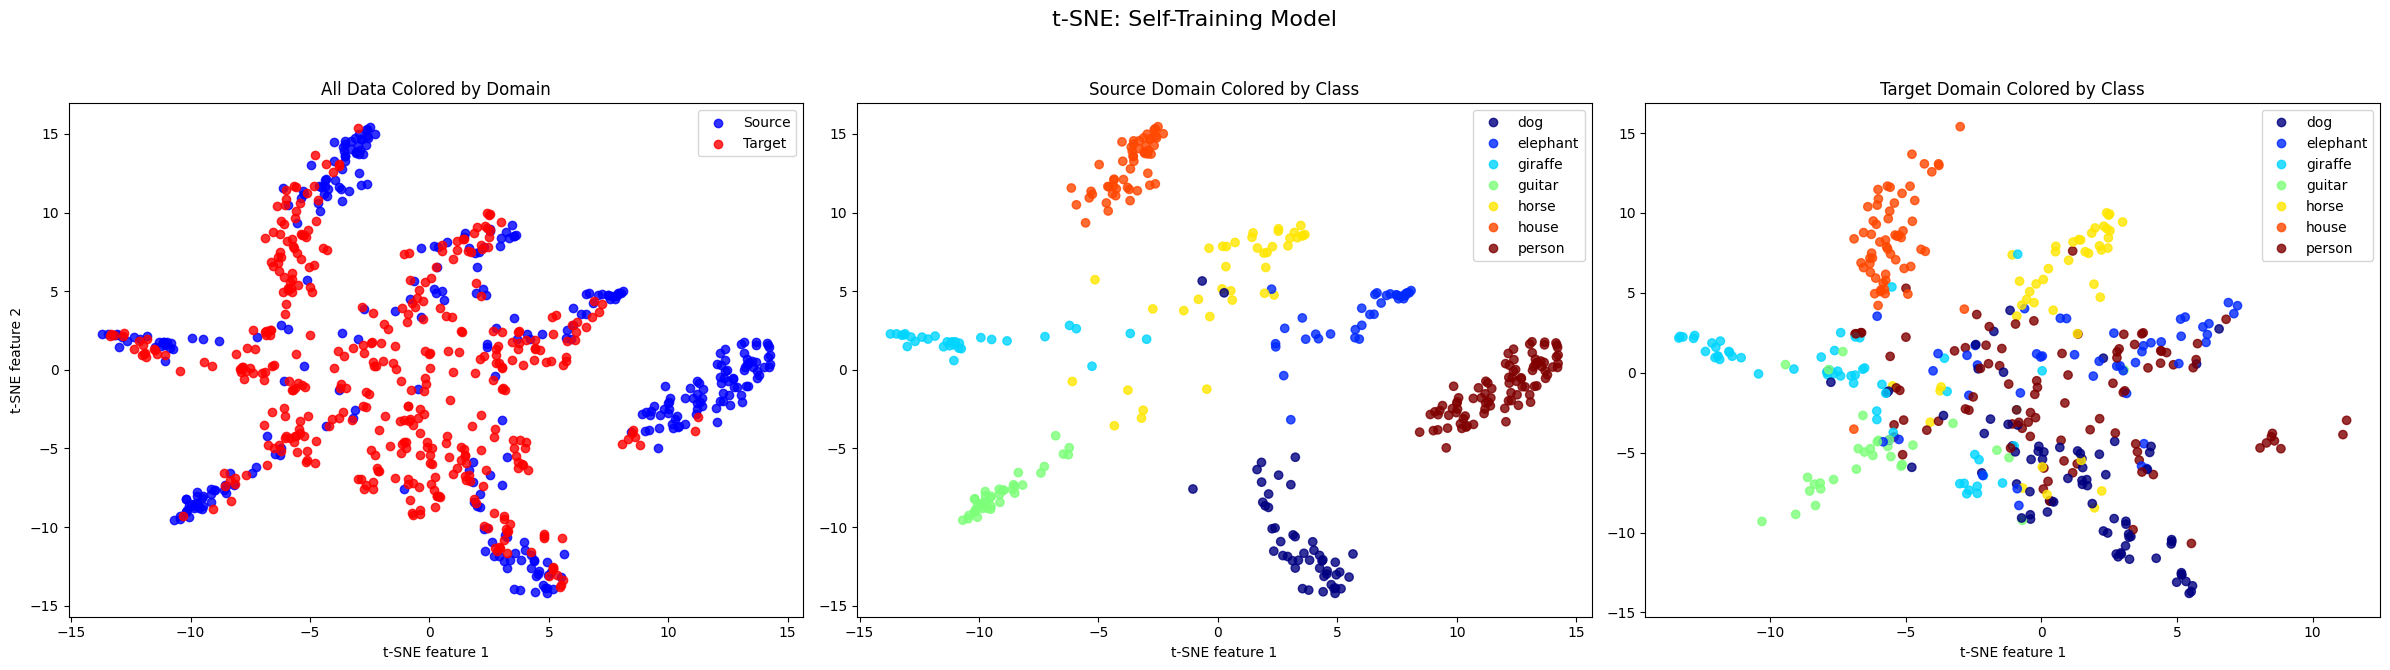

In [188]:
source_features_st, source_labels_st = get_features(self_training_model, source_test_loader, DEVICE)
target_features_st, target_labels_st = get_features(self_training_model, target_test_loader, DEVICE)
plot_tsne(source_features_st, source_labels_st, target_features_st, target_labels_st, "t-SNE: Self-Training Model", CLASSES)

In [ ]:
# torch.save(self_training_model.state_dict(), "self_training_model.pth")

self_training_model = resnet18(pretrained=True)
in_features = self_training_model.fc.in_features
self_training_model.fc = nn.Linear(in_features, NUM_CLASSES)

self_training_model.load_state_dict(torch.load("self_training_model.pth"))
self_training_model = self_training_model.to(DEVICE)

c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jibra\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Self-Training Proxy A-Distance Error: 0.0699


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


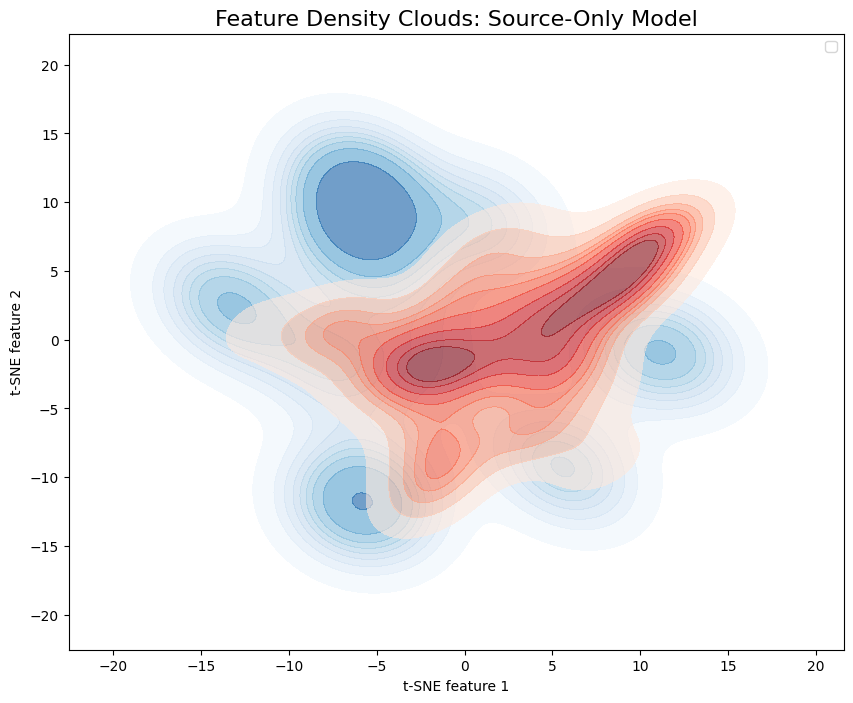

In [190]:
proxy_st = calculate_proxy_a_distance(source_features_st.cpu().detach().numpy(), target_features_st.cpu().detach().numpy(), SEED)
print(f"Self-Training Proxy A-Distance Error: {proxy_st:.4f}")

combined_features_st = np.vstack(
    (source_features_st.cpu().detach().numpy(), target_features.cpu().detach().numpy())
)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results_st = tsne.fit_transform(combined_features_st)

source_tsne_st = tsne_results_st[: len(source_features)]
target_tsne_st = tsne_results_st[len(source_features) :]

plot_kde_clouds(
    source_tsne_st,
    target_tsne_st,
    "Feature Density Clouds: Source-Only Model",
)



## Concept Shift

In [ ]:
rare_classes_indices = [CLASSES.index('dog'), CLASSES.index('elephant')]
downsample_ratio = 0.1 

def passthrough_transform(batch):
    return batch

target_test_set.set_transform(passthrough_transform)
original_test_labels = target_test_set['label']

target_test_set.set_transform(data_transforms)

original_test_indices = list(range(len(target_test_set)))

indices_to_keep = []
class_indices = [[] for _ in range(NUM_CLASSES)]
for i, label in enumerate(original_test_labels):
    class_indices[label].append(original_test_indices[i])

for i in range(NUM_CLASSES):
    if i in rare_classes_indices:
        num_to_keep = int(len(class_indices[i]) * downsample_ratio)
        kept_indices = np.random.choice(class_indices[i], num_to_keep, replace=False)
        indices_to_keep.extend(kept_indices)
    else:
        indices_to_keep.extend(class_indices[i])

label_shifted_dataset = target_test_set.select(indices_to_keep)
label_shifted_dataset.set_transform(data_transforms) 
label_shifted_loader = DataLoader(label_shifted_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate, shuffle=False)

print(f"Original target test set size: {len(target_test_set)}")
print(f"Created a label-shifted target test set with {len(label_shifted_dataset)} samples.")

Original target test set size: 410
Created a label-shifted target test set with 296 samples.


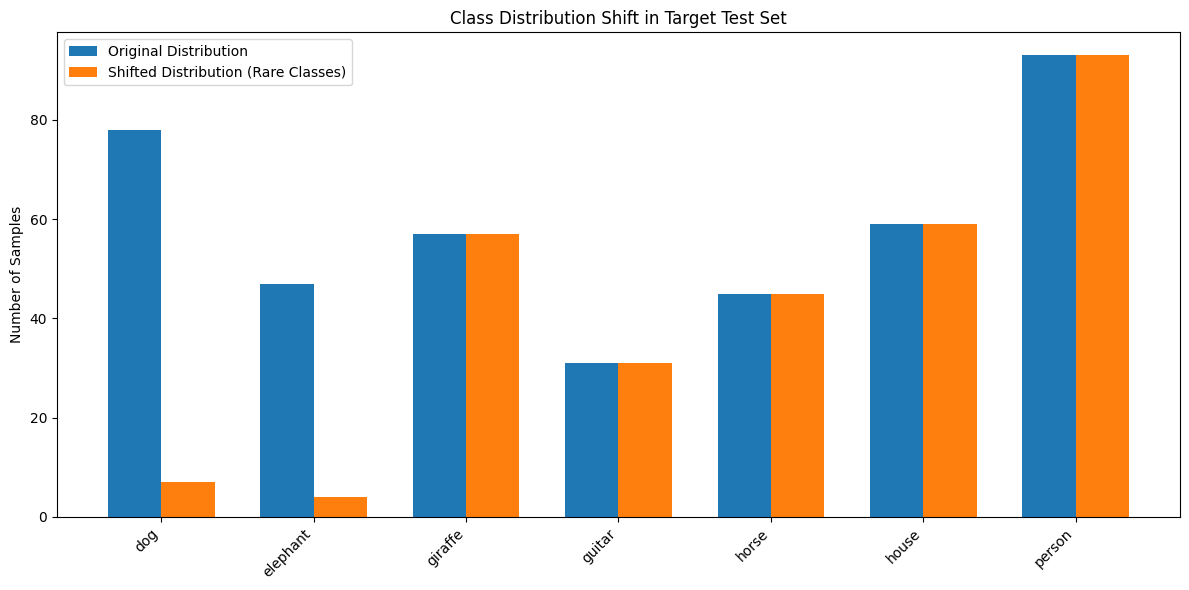

In [207]:
original_counts = np.bincount(original_test_labels, minlength=NUM_CLASSES)

def passthrough_transform(batch):
    return batch
label_shifted_dataset.set_transform(passthrough_transform)
shifted_counts = np.bincount(label_shifted_dataset['label'], minlength=NUM_CLASSES)

label_shifted_dataset.set_transform(image_transformer)

x = np.arange(NUM_CLASSES)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, original_counts, width, label='Original Distribution')
rects2 = ax.bar(x + width/2, shifted_counts, width, label='Shifted Distribution (Rare Classes)')

ax.set_ylabel('Number of Samples')
ax.set_title('Class Distribution Shift in Target Test Set')
ax.set_xticks(x)
ax.set_xticklabels(CLASSES, rotation=45, ha="right")
ax.legend()
fig.tight_layout()
plt.show()


Accuracy of Source-Only on shifted data: 0.4088


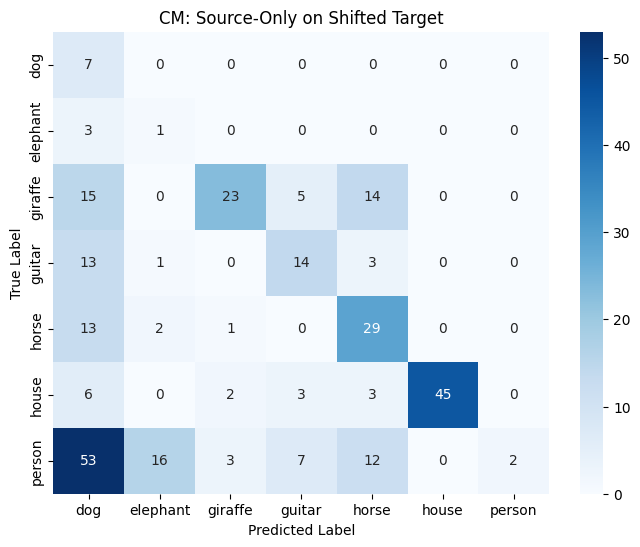


Accuracy of DAN on shifted data: 0.6993


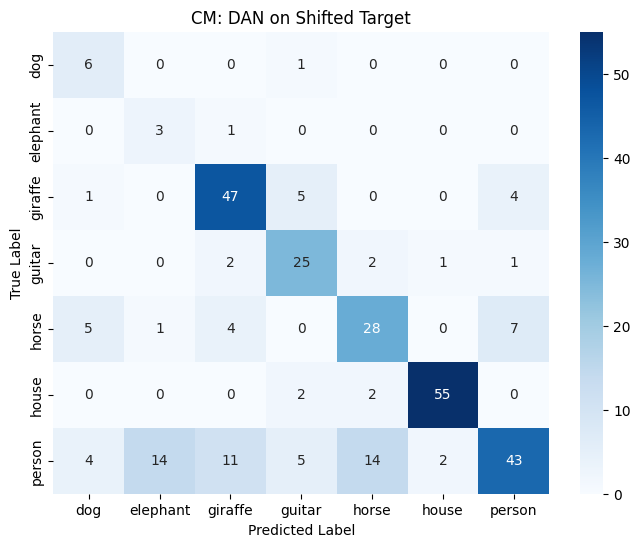


Accuracy of DANN on shifted data: 0.6318


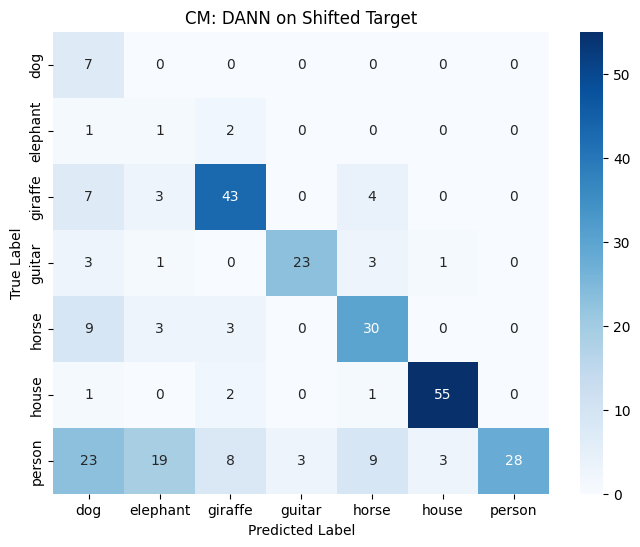


Accuracy of CDAN on shifted data: 0.7534


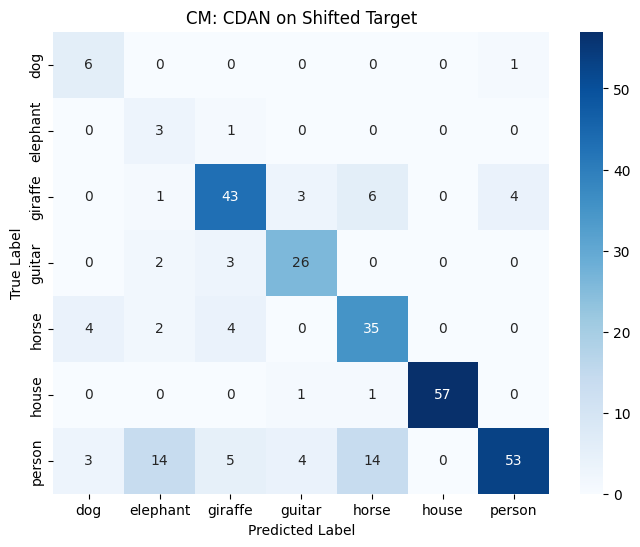


Accuracy of Self-Training on shifted data: 0.6014


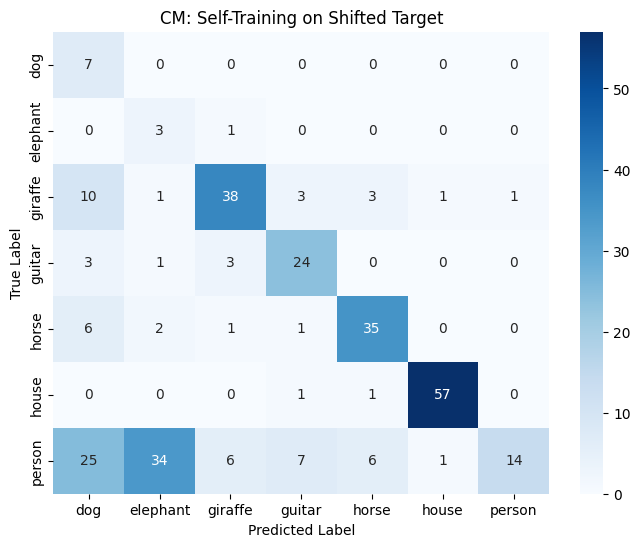

In [209]:
def plot_confusion_matrix(preds, labels, title, class_names):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

models_to_test = {
    'Source-Only': source_only_model,
    'DAN': dan_model,
    'DANN': dann_model,
    'CDAN': cdan_model,
    'Self-Training': self_training_model 
}


for name, model in models_to_test.items():
    if model:
        acc = evaluate(model, label_shifted_loader, DEVICE)
        results[name]['Target Acc (Shifted)'] = acc
        print(f"\nAccuracy of {name} on shifted data: {acc:.4f}")
        
        preds, labels = get_all_preds_labels(model, label_shifted_loader, DEVICE)
        plot_confusion_matrix(preds, labels, f"CM: {name} on Shifted Target", CLASSES)


In [217]:
print("\n--- Accuracy Comparison on Original vs. Shifted Target Test Set ---")
for name, model in models_to_test.items():
    if model:
        original_acc = results[name].get('Target Acc', 0)
        shifted_acc = results[name].get('Target Acc (Shifted)', 0)

        print(f"{name:<15}: Original = {original_acc * 100:.4f}%, Shifted = {shifted_acc * 100:.4f}%, [Difference = {(original_acc - shifted_acc) * 100:.4f}%]")


--- Accuracy Comparison on Original vs. Shifted Target Test Set ---
Source-Only    : Original = 47.3171%, Shifted = 40.8784%, [Difference = 6.4387%]
DAN            : Original = 62.9268%, Shifted = 69.9324%, [Difference = -7.0056%]
DANN           : Original = 66.0976%, Shifted = 63.1757%, [Difference = 2.9219%]
CDAN           : Original = 70.7317%, Shifted = 75.3378%, [Difference = -4.6061%]
Self-Training  : Original = 64.3902%, Shifted = 60.1351%, [Difference = 4.2551%]


In [218]:
print(results)

{'Source-Only': {'Source Acc': 0.9341317365269461, 'Target Acc': 0.47317073170731705, 'Target Acc (Shifted)': 0.40878378378378377}, 'DAN': {'Source Acc': 0.9550898203592815, 'Target Acc': 0.6292682926829268, 'Target Acc (Shifted)': 0.6993243243243243}, 'DANN': {'Source Acc': 0.9341317365269461, 'Target Acc': 0.6609756097560976, 'Target Acc (Shifted)': 0.6317567567567568}, 'CDAN': {'Source Acc': 0.9850299401197605, 'Target Acc': 0.7073170731707317, 'Target Acc (Shifted)': 0.7533783783783784}, 'Self-Training': {'Source Acc': 0.9670658682634731, 'Target Acc': 0.6439024390243903, 'Target Acc (Shifted)': 0.6013513513513513}}
